# Simulation of coal drop tube reactor

- Drop tube reactor.
- Coal is fed into a gas stream composed by CO2 and N2. 
- Assumptions
    - It is assumed that the coal feed is much lower than the gas feed  ($\dot{m}_c << \dot{m}_g$)
    - The gas composition is not affected by the char reactions (*one-way coupling*)

## Jupyter notebook

The Jupyter Notebook is a web application that allows you to create and share documents that contain 
- live code (`python`)
- equations (`latex`) 
- visualizations (`matplotlib`)
- explanatory text (`MarkDown`) 


- The first things to do in a `python` code/notebook is to import the external modules
- The function for evaluating the char conversion in a drop tube are contained in the module `char.py`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
try:
    plt.style.use(['mystyle', 'mystyle-nb'])
except:
    plt.style.use('ggplot')
%matplotlib inline

import char

The main input data for the Drop Tube Reactor are the following:

In [2]:
atm = 101325.0
Ptot = 10. # Total pressure, atm
Pg = 5. # Partial pressure of CO2, atm
Tg = 1600 # gas temperature
Twall = 1600 #wall temperature

The following intrinsic kinetics properties are assumed for the given coal:

In [3]:
kin = [1.79e6,  # pre-exp kg/s-m2
       335e6,   # activation energy J/kmol
       0.35     # reaction order
      ]    

Aint0 = 280e3  # specific intrinsic surface m2/kg
tauf=10.0      #structural char pore parameter
psi0 = 3.8     # structural parameter for the random pore model
dp = 100e-6    # particle diameter
Tp = 300.0     # particle temperature

The coal ultimate and proximate analysis are the following:

In [4]:
UA = np.array([75.8,  # C
               4.98,  # H
               16.73, # O
               1.38,  # N
               1.12]) # S
UA = UA/np.sum(UA)    # normalize
PA = np.array([51.8,  # fixed carbon
               36.2,  # volatile matter
               6.4,   # moisture
               5.6])  # Ash
PA = PA/np.sum(PA)    # normalize

Coal is at first dried, removing the moisture content:

In [5]:
PAdry = np.copy(PA)  # copy prox. analysis as received
PAdry[3] = 0         # set moisture to 0
PAdry = PAdry/np.sum(PAdry)  # normalize
PAdaf = np.copy(PAdry)       # copy dry prox. analysis 
PAdaf[2]=0           # set ash to 0
PAdaf=PAdaf/np.sum(PAdaf)    # normalize

During char production, the volatile yield produced at 1473K (obtained from CPD) is the following:

In [6]:
VMPA = PAdaf[1]  # daf volatile matter from prox. analysis
VM = 0.46        # daf volatiles produced at 1473K
Q = VM/VMPA      # Q-factor
print('Q factor: {:4.3f}'.format(Q))

Q factor: 1.118


In [7]:
Ydaf = PAdry[0]+PAdry[1] # daf mass fraction on dry basis
PAexp = np.copy(PAdry)
PAexp[1] = VM * Ydaf
PAexp[0]= 1 - PAexp[1] - PAexp[2]

- During pyrolysis, the mass of the dried particle is reduced from the value $m_{p,0}$ to $m_{p,1}$. 
- At the same time the diameter swells ($d_{p,1}=Sw\cdot d_{p,0}$).

- The *apparent density* becomes:

\begin{equation}
\frac{\rho_{p1}}{\rho_{p0}} = \frac{m_{p1}}{m_{p0}}\cdot \left(\frac{d_{p0}}{d_{p1}}\right)^3=\frac{1-y_{VM}}{Sw^3}
\end{equation}

- The initial density is calculated from the Merrick correlation, assuming the initial porosity:

In [8]:
Sw=1.05        # Swelling coefficient
eps0=0.3       # initial porosity
yash0=PAexp[2] # ash mass fraction
rhoT0 = char.trueDensity(UA, yash0) # initial true density from Merrick 
rho0 = rhoT0*(1-eps0)               # initial apparent density
yash1=PAexp[2]/(PAexp[1]+PAexp[2])  # ash fraction after pyrolysis
rhoT1 = char.trueDensity([1,0,0,0,0],yash1) # true density after pyro
                                            # only C in char
rho1 = rho0 * (1-PAexp[1])/pow(Sw,3)        # char apparent density
eps1 = 1-rho1/rhoT1                         # char porosity
print('Char true density: {:4.1f} kg/m3'.format(rhoT1))
print('Char app. density: {:4.1f} kg/m3'.format(rho1))
print('Char porosity:     {:1.3f}'.format(eps1)) 

Char true density: 2240.2 kg/m3
Char app. density: 479.8 kg/m3
Char porosity:     0.786


In [9]:
# calculate carbon density
rhoa = 1000. # ash apparent density
rhoc1 = (1-yash1)/(1./rho1-yash1/rhoa)
print('Carbon app. density: {:4.1f} kg/m3'.format(rhoc1))

Carbon app. density: 443.3 kg/m3


In [10]:
print('After DRYING')
print('rhoT0 = {:5.1f} kg/m3'.format(rhoT0))
print('rho0 = {:5.1f} kg/m3'.format(rho0))
print('eps0 = {:3.2f}'.format(eps0))
print('After PYROLYSIS')
print('rhoT1 = {:5.1f} kg/m3'.format(rhoT1))
print('rho1 = {:5.1f} kg/m3'.format(rho1))
print('eps1 = {:3.2f}'.format(eps1))
print('rhoc1 = {:5.1f}'.format(rhoc1))

After DRYING
rhoT0 = 1389.1 kg/m3
rho0 = 972.4 kg/m3
eps0 = 0.30
After PYROLYSIS
rhoT1 = 2240.2 kg/m3
rho1 = 479.8 kg/m3
eps1 = 0.79
rhoc1 = 443.3


### 3-Zone diagram

The reaction rate (1/s) is calculated by:

\begin{equation}
R = \eta a_i k_i P_s ^n,
\end{equation}

where the *effectiveness factor* is given by:

\begin{equation}
\eta = \frac{3}{\Phi}\left(\frac{1}{\tanh \Phi}-\frac{1}{\Phi}\right)
\end{equation}

This formula is valid only when the order of the reaction $n=1$. However, it is assumed to be valid also for generic reaction order.
The variable $\Phi$ is the Thiele modulus, expressed as follows:

\begin{equation}
\Phi = \frac{d_p}{2}\sqrt{\frac{\nu (n+1) a_i \rho_c k_i P^{n-1} R_g T_p}{2 M_c D_{eff}}}
\end{equation}

This definition of the Thiele modulus is equivalent to one used during the classes:

\begin{equation}
\Phi = \sqrt{\frac{n+1}{2}} \Phi_n
\end{equation}

If the conversion occurs in pore diffusion-limited regime, the effectiveness factor can be simplified to:

\begin{equation}
\eta \simeq \frac{3}{\Phi} = \sqrt{\frac{2}{n+1}}\frac{3}{\Phi_n},
\end{equation}

which is the formulation of the effectiveness factor in pore diffusion regime in the slides.

The diffusion flux through the film layer is given by:

\begin{equation}
q_d = -\alpha k_{d} P_t \ln \frac{x_\infty - \alpha}{x_s - \alpha},
\end{equation}

where the diffusion constant rate $k_{d} is$:

\begin{equation}
k_{d}=\frac{\text{Sh}D M_c}{R_g T_m d_p},
\end{equation}

and $\alpha=\frac{N}{N_{tot}}$ is the molar ratio between the total flux (= carbon flux) and the flux of the reactant. The molar fluxes are taken into account with their sign. I.e. reactant has a negative molar flux and the carbon flux is positive. Therefore $\alpha < 1$.

For the Boudouard reaction $N_{tot} = N_{CO} + N_{CO2} = 2 -1 = 1$ and $N_{CO2} = -1$, than $\alpha=-1$.

$q_d$ is the char mass rate per external surface unit:

\begin{equation}
R = \frac{6 q_d}{\rho_c d_p}
\end{equation}

The partial pressure $P_s$ can be calculated iteratively, solving the following equation

\begin{equation}
\eta a_i k_i \left(x_s P_t\right) ^n = \frac{6 \alpha k_{d}}{\rho_c d_p} P_t \ln \frac{x_s - \alpha}{x_\infty - \alpha}
\end{equation}

The Brent method can be used for solving numerically the non-linear equation (http://mathworld.wolfram.com/BrentsMethod.html).

## Diffusivity

The molecular diffusivity of the reactant can be calculated from:

\begin{equation}
D = K \cdot \frac{\left( \frac{T}{273.15}\right)^{1.81}}{\frac{P_t}{101325}}
\end{equation}

The constant $K$ for CO2 in N2 mixture is:

In [22]:
print('K={:4.3e}'.format(char.DT1))

K=1.402e-05


In [11]:
T = np.linspace(1200,2500) # temperature points
Deff = char.diffusivity(pressure=Ptot*atm,temperature=T) * eps1/tauf
# define a data array Npoints x 5
data = np.empty((len(T), 5))
for i, (Ti, deffi) in enumerate(zip(T, Deff)):
    data[i] = char.chi_parameter(dp=dp, Ptot=Ptot, Pinf=Ptot, Tinf=Ti, Tp=Ti, 
                                 rhoc=rhoc1, Aint=Aint0, Deff=deffi, 
                                 kinetics=kin, nu=1, Sh=2)
    

In [12]:
# copy values
ps = data[:, 0]      # surface pressure, atm
chi = data[:, 1]     # diffusion coefficient
rate = data[:, 2]    # rate 1/s
eff = data[:, 3]     # effectiveness factor
thiele = data[:, 4]  # Thiele modulus

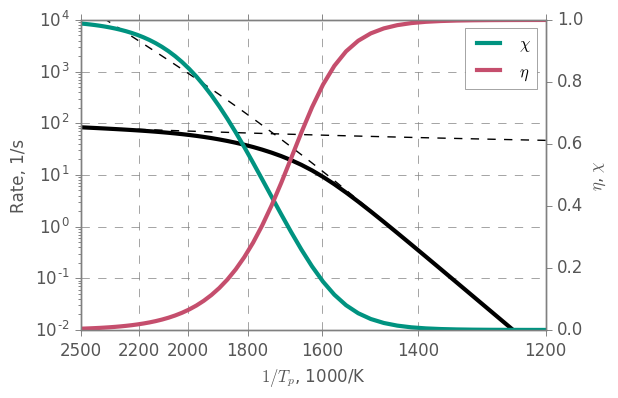

In [13]:
# plot 3-zone
fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(6, 4))
red = "#C54E6D"
green = "#009380"
# upper plot
one_T = 1000./T
ax.plot(one_T, rate, label='Observed rate', color='black', linestyle='solid', 
        linewidth=3)
ax.plot(one_T, rate/eff, label='Kinetic rate', color='black', 
        linestyle='dashed', linewidth=1)
ax.plot(one_T, rate/chi, label='Diffusion rate', color='black', 
        linestyle='dashed', linewidth=1)
ax.set_yscale('log')
ax.set_ylabel('Rate, 1/s')
ax.set_ylim([1e-2, 1e4])
ax.set_xlabel('$1/T_p$, 1000/K')
ax.set_xticklabels([])
ax.set_xlim(xmax=0.8)

T_label = [2500, 2200, 2000, 1800, 1600, 1400, 1200]
ax.set_xticks(1000./np.array(T_label))
ax.set_xticklabels(T_label)
ax1 = ax.twinx()
ax1.plot(one_T, chi, label='$\\chi$', color=green, linewidth=3)
ax1.plot(one_T, eff, label='$\eta$', color=red, linewidth=3)
ax1.set_ylabel('$\\eta$, $\\chi$')
ax1.legend(loc='best')
ax1.grid(False)
ax1.locator_params(axis='y', nbins=5)
#ax1.set_xlim(xmax=0.8);
fig.savefig('3zone.pdf', bbox_inches='tight')

### Drop tube reactor analysis

Char conversion is now analyzed in a drop tube reactor. 
The non-dimensional mass conversion is governed by the following equation:

\begin{equation}
\frac{dX}{dt}=R (1-X),
\end{equation}

where then observed rate is given by $R = \eta k_i a_i P_s^n $.
The particle temperature is given by:

\begin{equation}
m_p c_p \frac{dT_p}{dt} = h \frac{B}{e^B-1} A_p \left(T_g -T_p\right)+\sigma \epsilon A_p \left( T_w^4-T_p^4\right) - R m_c \Delta H_r
\end{equation}

The ODE system is numerically solved using scientific python (`scipy`).

The heat of the Boudouard reaction can be calculate by the energy balance of the reaction at the reference temperature:

\begin{equation}
\sum_{r}\nu_r h_{f,r} = \sum_{p}\nu_p h_{f,p} - \Delta H_r
\end{equation}

In [14]:
hfCO2 = -394.39  #kJ/mol
hfCO = -137.16  #kJ/mol
hfC = 0
DHr = 2 * hfCO - hfCO2 - hfC  # kJ/mol
DHr = DHr / 12.0 * 1e6  # J/kg
print('Heat of reaction C+CO2: {:5.2f} MJ/kg'.format(DHr / 1e6))

Heat of reaction C+CO2: 10.01 MJ/kg


The ODE is solved calling an external function in the `char.py` module:

In [15]:
time = 0.5  #overall residence time
sol = char.drop_tube(
    Tp0=Tp,
    time=time,
    dp0=dp,
    Ptot=Ptot,
    Pinf=Pg,
    Tg=Tg,
    Twall=Twall,
    rhop0=rho1,
    A0=Aint0,
    yash0=yash1,
    psi=psi0,
    tauf=tauf,
    DH=DHr,
    kinetics=kin,
    nu=1.0,
    Sh=2.0)

In [16]:
t = sol[0]
X = sol[1]
TP = sol[2]
Rhoc = sol[4]
Rhop = sol[5]
Chi = sol[6]
Robs = sol[7]
Blow = sol[8]
Eff = sol[9]
Dp = sol[10]

The char conversion as a function of the time is plotted:

(0, 1)

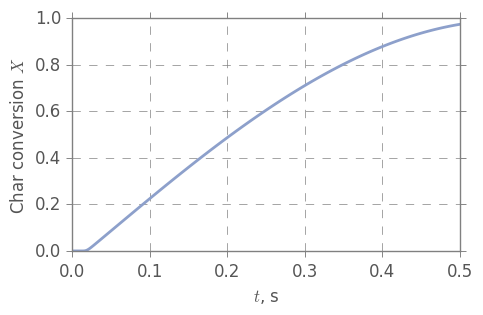

In [17]:
#plt.figure(0)
fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(5, 3))
ax.plot(t,X, label='X')
ax.set_xlabel('$t$, s')
ax.set_ylabel('Char conversion $X$')
ax.set_ylim([0, 1])
#plt.legend()


The particle is intruduced at ambient temperature and it is heated up very quickly:

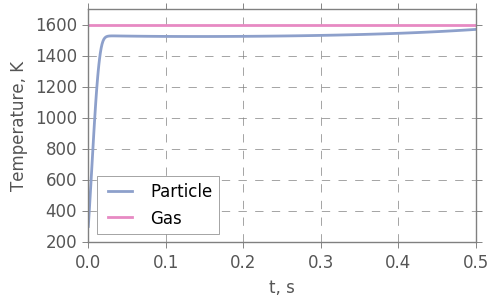

In [18]:
#fig, ax = plt.subplots()
fig, axes = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(5, 3))

ax = axes
#ax.set_xlim([0,0.01])
ax.plot(t, TP, label='Particle')
ax.plot(t, Tg*np.ones_like(TP), label='Gas')

ax.set_ylim(ymax=1700)
ax.set_ylabel('Temperature, K')
ax.legend(loc='best')

#ax = axes[1]
#plt.xlim([0,0.02])
#ax.plot(t,TP,'k-',linewidth=2,label='Particle')
#ax.plot(np.array([t[0],t[-1]]),np.array([Tg,Tg]),'r-',linewidth=2,label='Gas')
#ax.xlabel('t, s')
#ax.set_ylabel('Temperature, K')
ax.set_xlabel('t, s')
#ax.legend()



The apparent density of char evolves according to:

\begin{equation}
\rho_c = \rho_{c,0}\left( 1-X \right)^\alpha
\end{equation}

with $\alpha=0.95$.
The apparent density of the particle is:

\begin{equation}
\frac{1}{\rho_p} = \frac{1-y_{a}}{\rho_c}+\frac{y_{a}}{\rho_a}
\end{equation}

and $\rho_a$ is assumed constant during conversion.

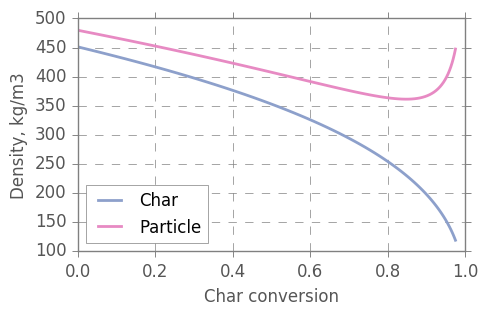

In [19]:
# 
fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(5, 3))
ax.plot(X,Rhoc, label='Char')
ax.plot(X,Rhop, label='Particle')
ax.set_xlabel('Char conversion')
ax.set_ylabel('Density, kg/m3')
ax.set_xlim([0, 1])
ax.legend()

The parameters $\eta$, $\chi$ and the blowing factor $B/(e^B-1)$ are plotted:

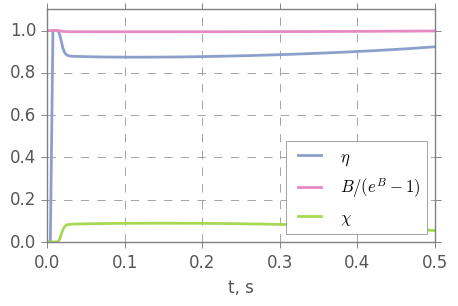

In [20]:
#plt.legend()
fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(5, 3))

ax.set_ylim([0,1.1])
#plt.xlim([0,0.1])
ax.plot(t, Eff, label='$\eta$')
ax.plot(t, Blow, label='$B/(e^B-1)$')
ax.plot(t, Chi, label='$\chi$')
ax.set_xlabel('t, s')
#ax.ylabel('')
ax.legend(loc=4)

The diameter evolves as follows:

(0, 1)

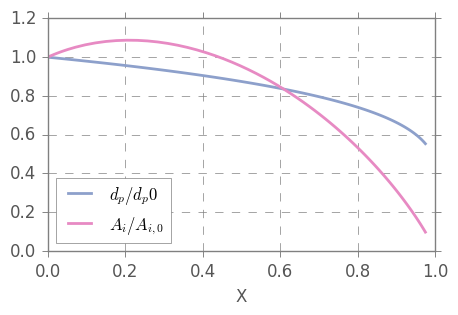

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(5, 3))
X = np.array(X)
a = char.RPM(X,1,psi0)*(1.-X)
ax.plot(X,Dp/Dp[0], label='$d_p/d_p0$')
ax.plot(X,a, label='$A_i/A_{i,0}$')
ax.set_xlabel('X')
ax.legend(loc=3)
ax.set_xlim([0, 1])